---

# Explanation of the Blade Element Theory (BEM) algorithm and Application on a 15MW Wind Turbine

---

**Author: Chung Anthony, Gouders Louis, Lambotte Augustin, Laridon Amaury**

**Goal**: This notebook is used in order to understand and explain with our own cords the BEM algorithm delivered for the Wind Turbine Project of the LENVI2007 course. 

In this notebook we copy the BEM.py script writen by Romain Debroeyer and we seperate it into differents parts in order to explain step by step the main procedures. The main reference for explaining the BEM is the *AeroDyn Theory Manual* (Moriarty and Hansen 2005) textbook.

---

## What is the Blade Element Theory ? 

### Concept and goal

The Blade Element Theory (BEM) is used to predict the aerodynamics of horizontal axis wind turbines and calculate the effect of wind turbine wakes. The method is also used to calculate the axial induced velocities from the wake in the rotor plane. BEM is the classical standard used by many wind turbine designers and is one of the oldest and most commonly used methods for calculating induced velocities on wind turbine blades.

The BEM theory, generally attributed to Betz and Glauert (1935), actually originates from two different theories: blade element theory and momentum theory (see Leishman 2000). 

- Blade element theory assumes that blades can be divided into small elements that act independently of surrounding elements and operate aerodynamically as two-dimensional airfoils whose aerodynamic forces can be calculated based on the local flow conditions. These elemental forces are summed along the span of the blade to calculate the total forces and moments exerted on the turbine. 

- The other half of BEM, the momentum theory, assumes that the loss of pressure or momentum in the rotor plane is caused by the work done by the airflow passing through the rotor plane on the blade elements. Using the momentum theory, one can calculate the induced velocities from the momentum lost in the flow in the axial and tangential directions. These induced velocities affect the inflow in the rotor plane and therefore also affect the forces calculated by blade element theory. This coupling of two theories ties together blade element momentum theory and sets up an iterative process to determine the aerodynamic forces and also the induced velocities near the rotor

The advantage of the BEM theory is that each blade element is modeled as a two-dimensional airfoil.

### Limitations

Because of its simplicity, BEM theory does have its limitations. 

- One primary assumption is that the calculations are static; it is assumed that the airflow field around the airfoil is always in equilibrium and that the passing flow accelerates instantaneously to adjust to the changes in the vorticity in the wake. In practice, it has been shown that the airfoil response takes time to adjust to a changing wake resulting from new inflow or turbine operating conditions (Snel and Schepers 1995).

- One other limitation is that BEM theory breaks down when the blades experience large deflections out of the rotor plane. Because the theory assumes that momentum is balanced in a plane parallel to the rotor, any deflections of the rotor will lead to errors in the aerodynamic modeling.

- Another limitation of BEM theory comes from blade element theory. This theory is based on the assumption that the forces acting on the blade element are essentially two-dimensional, meaning that spanwise flow is neglected. This assumption also implies that there is very little spanwise pressure variation (which would create spanwise flow), and the theory is therefore less accurate for heavily loaded rotors with large pressure gradients across the span.

- Some other limitations of the original theory include no modeling of tip or hub vortex influence on the induced velocities and an inability to account for skewed inflow. These tip vortices create multiple helical structures in the wake and they play a major role in the induced velocity distribution at the rotor. The effect on induced velocity in the rotor plane is most pronounced near the tips of the blades, an area that also has the greatest influence on the power produced by the turbine.

- Another limitation of the BEM theory is that when the induction factor is greater than about 0.4, the basic theory becomes invalid. This occurs with turbines operating at high tip speed ratios (e.g. constant speed turbine at low wind speeds), as the rotor enters what is known as the turbulent wake state $(a > 0.5).$


---
## Analysis and explanation of the BEM script
Libraries 

In [1]:
# -*- coding: utf-8 -*-
"""
Created on November 15 2022

@author: Romain Debroeyer
"""

import numpy as np
import scipy.interpolate as sp

### BEM function 

#### What is it used for ? 
**This is the main function of the BEM algorithm.** 

It **takes as entry** the **wind speed, the angular velocity of the blade, the pitch, the chord, the number of blades** for the wind turbine consider and lastly the relevant data with respect to the **specific airfoils consider.** 

The **algorithm is used to compute** and deliver the **Thrust (T), the Torque (Q) and the Power (P)** for the total wind turbine given the specific inputs. 

The BEM algorithm computes the contribution to the force and the torque** based on the force on the airfoil and the equals it with the contribution to the force and torque based on the momentum balance. 

It **computes the Thrust and Torque for every for every discrete element of the blade and then integrate it** along the entire length of the blade.

#### Technical description

Here we will explained the script in details. We will refer to the lines of codes for more clarity. 

- **Parameters**
    - **U**, **pitch** and **Omega** are float value: **pitch** and **omega** are the prescribed pitch angle and angular speed for the corresponding wind speed value **U**

    - **r**, **twist**, **chord** and **airfoil** are list of the same length
        
        - **twist** and **chord** are the twisting value and the chord lenght of the element of the blade located at a distance **r** of the center
        
        - **airfoil** is the profile of the airfoil at distance **r** : It's refering to the .dat files. In these file the value of C_l and C_d are given (second and third raws) depending of the attack angle (first raw). These value will be interpolated using getInterpolator function.

    - **B** is an integer: number of blade.

    
    
- **Line 3 to line 13 are parameters definition and instancing.** 

    - Line 3 is a conversation of the pitch angle from degres to radian. 
    
    - Line 4 define the number of discrete steps of integration based on the number of discrete segments of the blade on which will be computed the quantities. 

    - Line 6 and 7 defines the vectors that will contains the values of $a$ and $a'$.

    - Line 9 defines $\omega$ DON'T UNDERSTAND IT

    - Line 10 and 11 are parameters for the integration, the maximum number of iteration at the tolerance of error threshold. 

    - Line 13 defines the density of the air. 

- **Line 14 to 38 is the main BEM algorithm:**

    - **Objectif of this loop**
    
         Compute a and a' for each blade element - iteration is over the length of r list

    - **Main idea**

        Starting by taking $a$ and $a'$ at zeros, meaning no wind deviation, we compute the thrust and torque effect. These one modify the air circulation and hence $a$ and $a'$, which in turn modify the torque and thrust effect,... This computation is done iteratively until the difference is smaller than the tolerence (tol param) 
    - **Detail**

        - Line 15: create interpolator for C_l and C_d: given an angle of attack in radians they return the interpolated C_l and C_d - c_l = clinterp(alpha)
        
        - Line 16: is a conversation of the twist angle from degree to radian.

        - Line 18: initialisation of xnew = [0,0]. These are the first value of a and a'. 

        - Line 21: computation of $a_{new}$ and $a'_{new}$ using the function f.

        - Line 24: $a^{(')}_k = (1-\Omega) a^{(')}_{old} + \Omega a^{(')}_{new}$ **WHY??**

In [2]:
def f(x,U,Omega,r,B,c,clinterp,cdinterp,beta,pitch):
    # system of equations to be solved
    # x[0] = a
    # x[1] = a'
    y = np.copy(x)
    yaxis = U * (1-x[0])
    xaxis = Omega*r*(1+x[1])
    phi  = np.arctan2(yaxis,xaxis)

    alpha = phi - beta - pitch

    cl = clinterp(alpha)
    cd = cdinterp(alpha)
    cN = cl*np.cos(phi)+cd*np.sin(phi)
    cT = cl*np.sin(phi)-cd*np.cos(phi)
    
    V_res = np.sqrt((U*(1-x[0]))**2 + (Omega * r * (1+x[1]))**2)

    dT = B * 0.5 * V_res**2 * (cl * np.cos(phi) + cd * np.sin(phi)) * c  # We omit rho and dr in these two equations, because they will be canceled out in the fraction below 
    dQ = B * 0.5 * V_res**2 * (cl * np.sin(phi) - cd * np.cos(phi)) * c * r

    y[0] = dT / (4*np.pi*r*U**2*(1-x[0])) # rho and dr are absent from these two fractions, because they cancel out at the numerator and denominator
    y[1] = dQ / (4*np.pi*r**3*U*(1-x[0])*Omega)

    return y

def getInterpolator(airfoilName):
    """
    
    Parameters
    ----------
    airfoilName : String
        Name of the airfoil - must correspond to the .dat filename of the polar, without the extension

    Returns
    -------
    cl_interp : 
        interpolator for the lift coefficient. Its argument is the angle of attack (alpha) angle 
    cd_interp : TYPE
        interpolator for the drag coefficient. Its argument is the angle of attack (alpha) angle 

    """
    f = open(airfoilName+".dat")    
    lines = f.readlines()    

    angle = np.zeros(0)
    cl = np.zeros(0)
    cd = np.zeros(0)

    index = 0
    startindex = 100    
    for line in lines:
        data = line.split()
        if len(data) > 0 and data[0] == '-180.00':
            startindex = index
        if index >= startindex and len(data)>0:
            angle = np.append(angle,float(data[0])* np.pi/180) 
            cl = np.append(cl,float(data[1]))
            cd = np.append(cd,float(data[2])) 

        index += 1
    cl_interp = sp.interp1d(angle,cl)
    cd_interp = sp.interp1d(angle,cd)

    return cl_interp,cd_interp

def BEM(U, Omega, pitch, r, twist, chord, B, airfoils):
    
    pitch *= np.pi / 180
    n =  len(r)
    
    a = np.zeros(n)
    ap = np.zeros(n)
    
    omega = 0.3
    iter_max = 150
    tol = 1e-12
    
    rho = 1.225
    for i in range(n):
        clinterp,cdinterp = getInterpolator(airfoils[i])
        beta = twist[i] * np.pi / 180
        
        xk_1 = np.array((a[i],ap[i])) # = [0,0]

        iiter = 0
        xnew = f(xk_1,U,Omega,r[i],B,chord[i],clinterp,cdinterp,beta,pitch)
        xk = np.copy(xnew)
        for j in (0,1):
            xk[j] = (1-omega)*xk_1[j] + omega*xnew[j]
            
        while (abs(xk[0]-xk_1[0])>tol and abs(xk[1]-xk_1[1])>tol and iiter<iter_max):
            xk_1 = np.copy(xk)
            xnew = f(xk_1,U,Omega,r[i],B,chord[i],clinterp,cdinterp,beta,pitch)
            for j in (0,1):
                xk[j] = (1-omega)*xk_1[j] + omega*xnew[j]           
            iiter = iiter + 1
            
        if(iiter==iter_max):
            print('No convergence for airfoil ' + airfoils[i] +' at wind speed {:d} m/s - residual is {:.2e}'.format(U,max(abs(xk[0]-xk_1[0]),abs(xk[1]-xk_1[1]))))
            xk[0] = 0
            xk[1] = 0
            
        a[i] = xk[0]
        ap[i] = xk[1]
    dT = 4*np.pi*r*rho * U**2 * (1-a) * a
    dQ = 4*np.pi*r**3*rho*U*(1-a)*ap*Omega
    T = np.trapz(dT,r)
    Q = np.trapz(dQ,r)

    P = Omega * Q

    return T,Q,P

def test():
    
    # global parameters of the turbine 
    U = 3
    rpm = 7
    pitch = 0
    Omega = rpm * 2 * np.pi/60

    # blade data  
    B = 3
    r =  np.array([2.8667,5.6,8.3333,11.75,15.85,19.95,24.05,28.15,32.25,36.35,40.45,44.55,48.65,52.75,56.1667,58.9,61.6333])
    twist =  np.array([13.308,13.308,13.308,13.308,11.48,10.162,9.011,7.795,6.544,5.361,4.188,3.125,2.319,1.526,0.863,0.37,0.106])
    chord =  np.array([3.542,3.854,4.167,4.557,4.652,4.458,4.249,4.007,3.748,3.502,3.256,3.01,2.764,2.518,2.313,2.086,1.419])

    airfoils = ["Cylinder1","Cylinder1","Cylinder2","DU40_A17","DU35_A17","DU35_A17","DU30_A17","DU25_A17","DU25_A17","DU21_A17","DU21_A17","NACA64_A17","NACA64_A17","NACA64_A17","NACA64_A17","NACA64_A17","NACA64_A17"]

    
    _,_,P = BEM(U,Omega,pitch,r,twist,chord,B,airfoils)

test()

No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 6.52e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.21e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.07e+00
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.84e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.76e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 5.08e+00


### Solver
#### Main idea
For a given blade element and a given value of the wind deviation induced by the turbine ($a$ and $a'$) we compute the thrust and the torque exerced on this blade element using eq [3] and eq [4] in ref *ad-theory.pdf*. 
\begin{equation}
\begin{split}
&dT = B \frac{1}{2} \rho V^2_{total}(C_l cos\phi + C_d sin\phi)c\ dr\\
&dQ = B \frac{1}{2} \rho V^2_{total}(C_l sin\phi - C_d cos\phi)cr\ dr
\end{split}
\end{equation}
In turn, these torque and thrust modify the air circulation in the vicinity of the turbine which modify $a$ and $a'$ followind eq [5] and [6] in the same reference.
\begin{equation}
\begin{split}
& a_{new} = \frac{dT}{4 \pi r \rho U^2_\infty (1 - a_{old}) dr}\\
& a'_{new} = \frac{dQ}{4 \pi r^3 U_\infty \Omega (1 - a_{old}) dr}
\end{split}
\end{equation}
**Problem** *Here this is indeed the equations used in the code but the inversion of eq[5] in the ref to produce the equation of $a_{new}$ above isn't correct. I had to choose one of the $a$ as $a_{old}$, and an other as $a_{new}$ in eq[5]. I missed something...*


**Possible explanation** This could be because When we take the equations from ENVI_2007_General_Intro_2023.pdf for $dT$ and $dQ$ we have
\begin{equation}
\begin{split}
&dT = \underbrace{2\pi r dr \rho U_{\infty} (1-a)}_{old} \underbrace{(U_\infty - U_{wake})}_{new}\\
&dQ = \underbrace{2\pi r dr \rho U_{\infty} (1-a)}_{old} \underbrace{2a'\Omega r^2}_{new}
\end{split}
\end{equation}
If we replace $U_{wake}$ by its expression depending on $a$ and if we consider the $a$ over "*old*" as $a_{old}$ and the $a$ and $a'$ over "*new*" as $a_{new}$ and $a'_{new}$ we are good. It can be physically justified because the first part of the equations are the wind incoming which didn't had the time to adjust and the left part of the equations represent the air movement in the turbine that adjust directly with the modification of thrust and torque.
#### parameters
- x is a list of length 2, $x[0] = a_{old}$ and $x[1] = a'_{old}$
#### Technical description

- Line 6 to 10 compute the angle of attack alpha and the local inflow angle phi
    - yaxis is the wind component perpendicular to the rotation plane
    - xaxis is the wind component parallel to the rotation plane

- Line 12 and 13 use the interpolation function to interpolate the value of cl and cd for the given angle of attack alpha

- Line 17 compute the total wind (V_res in the code = V_tot in the references), could be simplified as V_res = np.sqrt(xaxis^2 + yaxis^2) 

- Line 19 and 20 compute the element of thrust and torque as equations [3] and [4] in ref *ad-theory.pdf*

- Line 22 and 23 inverse the equations [5] and [6] in the same ref.


In [3]:

def f(x,U,Omega,r,B,c,clinterp,cdinterp,beta,pitch):
# system of equations to be solved
# x[0] = a
# x[1] = a'
    y = np.copy(x)
    yaxis = U * (1-x[0])
    xaxis = Omega*r*(1+x[1])
    phi  = np.arctan2(yaxis,xaxis)

    alpha = phi - beta - pitch

    cl = clinterp(alpha)
    cd = cdinterp(alpha)
    cN = cl*np.cos(phi)+cd*np.sin(phi)
    cT = cl*np.sin(phi)-cd*np.cos(phi)
    
    V_res = np.sqrt((U*(1-x[0]))**2 + (Omega * r * (1+x[1]))**2)

    dT = B * 0.5 * V_res**2 * (cl * np.cos(phi) + cd * np.sin(phi)) * c  # We omit rho and dr in these two equations, because they will be canceled out in the fraction below 
    dQ = B * 0.5 * V_res**2 * (cl * np.sin(phi) - cd * np.cos(phi)) * c * r

    y[0] = dT / (4*np.pi*r*U**2*(1-x[0])) # rho and dr are absent from these two fractions, because they cancel out at the numerator and denominator
    y[1] = dQ / (4*np.pi*r**3*U*(1-x[0])*Omega)

    return y

### Interpolator

The .dat files are filled with data giving the C_l (second raw in the .dat), c_d (third raw) in function of the attack angle (first raw, from -180° to 180°).

This function download these data and construct two interpolators **cl_interp** and **cd_interp**.

#### Usage : 
if we want to know cl for a given angle of attack alpha and a given air foil name:
- cl_interp, cd_itnerp = getInterpolator('airfoilname')
    
- cl = cl_interp(alpha)    **with alpha in radians**

In [4]:
def getInterpolator(airfoilName):
    """
    
    Parameters
    ----------
    airfoilName : String
        Name of the airfoil - must correspond to the .dat filename of the polar, without the extension

    Returns
    -------
    cl_interp : 
        interpolator for the lift coefficient. Its argument is the angle of attack (alpha) angle 
    cd_interp : TYPE
        interpolator for the drag coefficient. Its argument is the angle of attack (alpha) angle 

    """
    f = open(airfoilName+".dat")    
    lines = f.readlines()    

    angle = np.zeros(0)
    cl = np.zeros(0)
    cd = np.zeros(0)

    index = 0
    startindex = 100    
    for line in lines:
        data = line.split()
        if len(data) > 0 and data[0] == '-180.00':
            startindex = index
        if index >= startindex and len(data)>0:
            angle = np.append(angle,float(data[0])* np.pi/180) 
            cl = np.append(cl,float(data[1]))
            cd = np.append(cd,float(data[2])) 

        index += 1
    cl_interp = sp.interp1d(angle,cl)
    cd_interp = sp.interp1d(angle,cd)
    
    return cl_interp,cd_interp

Other function

In [5]:
def clcd(clinterp,cdinterp,alpha):
    return clinterp(alpha),cdinterp(alpha)

---

## Application example on a NREL 5MW Wind Turbine

Script from Romain Debroeyer

---

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on November 15 2022

@author: Romain Debroeyer
"""

import matplotlib.pyplot as plt

No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 6.52e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.21e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.07e+00
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.84e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 1.76e-01
No convergence for airfoil NACA64_A17 at wind speed 3 m/s - residual is 5.08e+00
24.279383850618192
No convergence for airfoil NACA64_A17 at wind speed 4 m/s - residual is 1.61e-02
No convergence for airfoil NACA64_A17 at wind speed 4 m/s - residual is 4.85e-02
No convergence for airfoil NACA64_A17 at wind speed 4 m/s - residual is 7.16e-02
No convergence for airfoil NACA64_A17 at wind speed 4 m/s - residual is 6.80e-02
No convergence for airfoil NACA64_A17 at wind speed 4 m/s - residual is 1.63e-01
109.6970545253914
No convergence for airfoil NACA64_A17 at wind speed 5 m/s - residual is 

Text(0, 0.5, '$P$ $[kW]$')

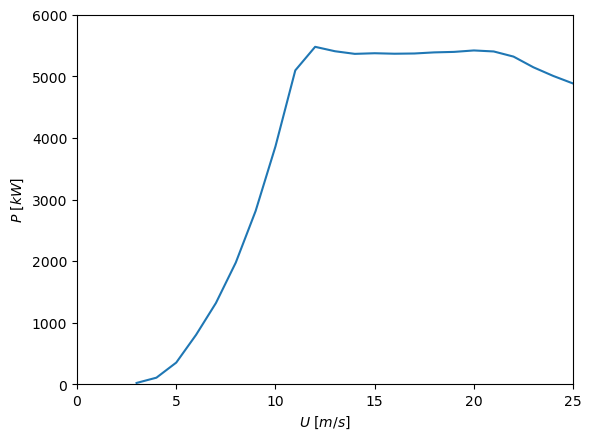

In [7]:
# global parameters of the turbine 
U = np.array([3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]  )
rpm = np.array([7, 7.2, 7.5, 8, 8.5, 9.1, 10.2, 11.4, 11.9, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1, 12.1 ])
pitch = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3.83, 6.60, 8.70, 10.45, 12.06, 13.54, 14.92, 16.23, 17.47, 18.70, 19.94, 21.18, 22.35, 23.47])
Omega = rpm * 2 * np.pi/60

# blade data  
B = 3
r =  np.array([2.8667,5.6,8.3333,11.75,15.85,19.95,24.05,28.15,32.25,36.35,40.45,44.55,48.65,52.75,56.1667,58.9,61.6333])
twist =  np.array([13.308,13.308,13.308,13.308,11.48,10.162,9.011,7.795,6.544,5.361,4.188,3.125,2.319,1.526,0.863,0.37,0.106])
chord =  np.array([3.542,3.854,4.167,4.557,4.652,4.458,4.249,4.007,3.748,3.502,3.256,3.01,2.764,2.518,2.313,2.086,1.419])

airfoils = ["Cylinder1","Cylinder1","Cylinder2","DU40_A17","DU35_A17","DU35_A17","DU30_A17","DU25_A17","DU25_A17","DU21_A17","DU21_A17","NACA64_A17","NACA64_A17","NACA64_A17","NACA64_A17","NACA64_A17","NACA64_A17"]

N = len(U)
P = np.zeros(N)
for k in range(N):
    _,_,P[k] = BEM(U[k],Omega[k],pitch[k],r,twist,chord,B,airfoils)
    print(P[k]*1e-3)

plt.figure('P')
plt.plot(U, P*1e-3)
plt.xlim([0,25])
plt.ylim([0,6000])
plt.xlabel(r"$U$ $[m/s]$")
plt.ylabel(r"$P$ $[kW]$")

---

## Application of the BEM on the IEA 15MW Wind Turbine

--- 

### Estimation of the torque and power of the IEA 15MW Turbine at selected wind speeds and look at the induction factors obtained

### Comparaison between calculated values with the actual torque/power curves 

#### Comment on hypothesis and simplifications

---
## IEA 15 MW Wind Turbine annual energy production and load factor

---

Following the slides on the *Wind_2021.pdf* course we see that in order to compute the annual energy production we have to combine the caracterstic power curve of our wind turbine (Power produced/Wind speed graph) obtained before and by combining this with the speed monotone we determine a power monotone.

Weather data loading

In [12]:
# Libraries # 
import pandas as pd
import matplotlib.pyplot as plt

# CSV File reading for weather data # 

personal_data_path = '../Data/'
df_wind = pd.read_csv(personal_data_path+ 'Weather_data_150m_height.csv', header=0, usecols=[0,1]) 

wind = df_wind['wind_speed']


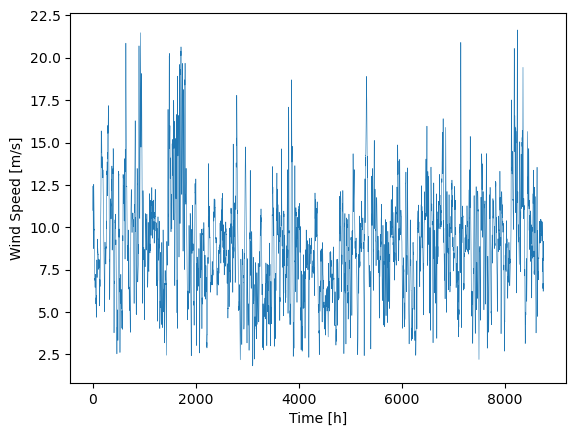

In [19]:
## Plot Wind Distribution ## 

plt.plot(np.arange(0, len(wind), 1), wind, lw=0.4)
plt.xlabel('Time [h]')
plt.ylabel('Wind Speed [m/s]')
plt.show()

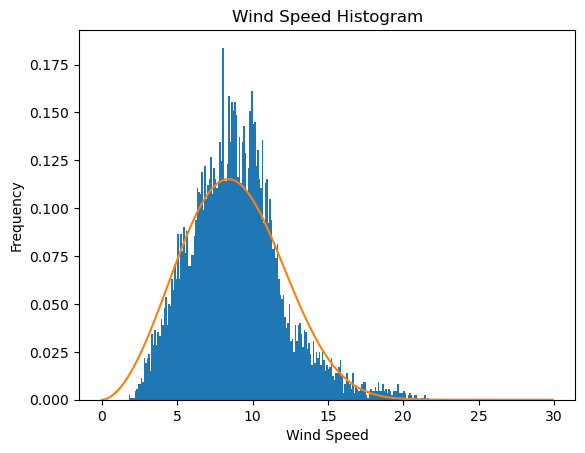

In [53]:
wind_speed_range = np.arange(0, 30, 0.1)
hist, bins = np.histogram(wind, bins=wind_speed_range)


def weibull(u, k, c):
    return (k / c) * (u / c)**(k-1) * np.exp(-(u/c)**k)

k = 2.85 #2.12
c = 9.767
Proba = []
for i in wind_speed_range :
    proba_temp = weibull(i, k, c)
    Proba.append(proba_temp)  

    

plt.hist(wind, bins=wind_speed_range,density=True)
plt.plot(wind_speed_range, Proba)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.title('Wind Speed Histogram')
plt.show()


Computation of the mean velocity of the wind during the year

In [11]:
mean_wind = np.mean(wind)
print("Mean velocity of the wind = {:.3f} m/s".format(mean_wind))

Mean velocity of the wind = 8.933 m/s
